In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import visual_behavior.data_access.loading as loading

### get example experiment

In [7]:
experiments_table = loading.get_filtered_ophys_experiment_table() 

In [87]:
experiment_id = experiments_table[experiments_table.session_type=='OPHYS_1_images_B'].index.values[20]

In [88]:
dataset = loading.get_ophys_dataset(experiment_id)

loading data for 958435363_476067_190924_VISp_175_cre_line_unknown_2P5_behavior_5imagesB


#### get stimulus template and plot image

In [ ]:
st = dataset.stimulus_presentations.copy()

In [101]:
image_set = dataset.metadata['session_type'][15]
templates = dataset.stimulus_templates
key = list(dataset.stimulus_templates.keys())[0]
images = dataset.stimulus_templates[key]
print(key)
print(images.shape)

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\sync_dataset.py:109: UserWarning:

The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\sync_dataset.py:109: UserWarning:

The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.



Natural_Images_Lum_Matched_set_ophys_6_2017.07.14_2
(8, 918, 1174)


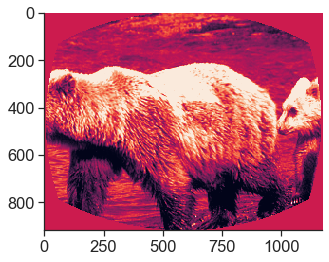

In [102]:
image_index = 0
image_name = st[st.image_index==image_index].image_name.values[0]
image = images[image_index,:,:]

plt.imshow(image)

The images provided in the SDK are cropped but not warped, and are not clearly associated with the image name, one has to use the image index from stimulus presentations to index into the stimulus templates - this is undesirable. The image name string should be directly linked to the image array, preferrably in a dataframe along with other metadata. exampe of this shown below.

### get image dictionary file name from SDK stimulus template

In [96]:
dataset = loading.get_ophys_dataset(experiment_id)
templates = dataset.stimulus_templates
key = list(dataset.stimulus_templates.keys())[0]
print(key)

loading data for 958435363_476067_190924_VISp_175_cre_line_unknown_2P5_behavior_5imagesB
Natural_Images_Lum_Matched_set_ophys_6_2017.07.14_2


### get image dictionary file path from pkl file for a specific session

In [94]:
import visual_behavior.database as db

ophys_session_id = experiments_table.loc[experiment_id].ophys_session_id
pkl_path = db.get_pkl_path(session_id=ophys_session_id, id_type='ophys_session_id') 
# stupid way of converting linux path to windows
pkl_path = os.path.abspath(pkl_path)
pkl_path = '\\'+pkl_path[2:]
# read file
data = pd.read_pickle(pkl_path)
print(data['items']['behavior']['params']['stimulus'])

{'params': {'image_set': '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/image_dictionaries/Natural_Images_Lum_Matched_set_ophys_6_2017.07.14.pkl', 'sampling': 'even'}, 'class': 'images'}


Why is the filename different in SDK compared to pkl file? SDK filename as '_2' at the end...

### get original images from image dictionary

In [103]:
image_set_A_path  = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_training_2017.07.14.pkl"
images_A = pd.read_pickle(image_set_A_path)

image_set_B_path  = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_ophys_6_2017.07.14.pkl"
images_B = pd.read_pickle(image_set_B_path)

image_set_G_path  = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_ophys_G_2019.05.26.pkl"
images_G = pd.read_pickle(image_set_G_path)

image_set_H_path  = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_ophys_H_2019.05.26.pkl"
images_H = pd.read_pickle(image_set_H_path)

### Create cropped and warped images from original image files

#### resize image to match monitor

In [166]:
from allensdk.brain_observatory.stimulus_info import Monitor

https://github.com/AllenInstitute/AllenSDK/blob/ac4ca73a6f47caa1a18295ae56c3a8848635bfb0/allensdk/brain_observatory/stimulus_info.py

In [167]:
# input known screen size (24 inch) and pixel resolution of images
monitor = Monitor(n_pixels_c=1920, n_pixels_r=1200, panel_size=60.96, spatial_unit='cm')

In [168]:
# select image from original image files
image_names = list(images_A.keys())
image_name = image_names[0]

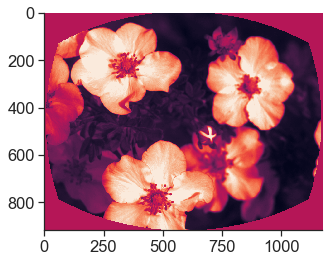

In [169]:
# original images are already cropped
image_array = images_A[image_name][image_name]
plt.imshow(image_array)

Warping is applied to stimulus to account for distance of the flat screen to the eye at each point on the monitor. When warped images are displayed on the screen, the edges of the images fall off the edge of the screen. The images saved in the image dictionaries have been cropped to remove the pixels that were not displayed to the mouse after warping. 


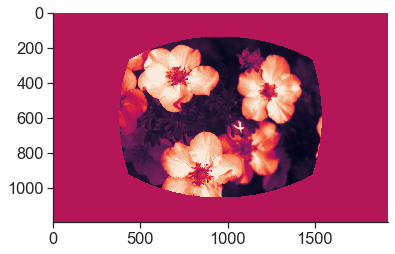

In [170]:
# resize image to fit monitor dimensions
resized_image = monitor.natural_scene_image_to_screen(image_array, origin='upper')
plt.imshow(resized_image)

#### make a version of the cropped image with NaNs in the background 

The background of the cropped images saved in the image dictionaries is gray, but we would like it to be NaNs so that we can compute image properties without including any values in the region outside the cropped area

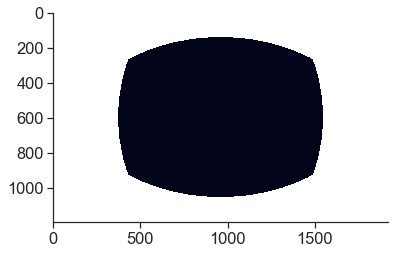

In [193]:
# get the cropping mask in screen coordinates
mask = monitor.get_mask()
mask[mask==0] = np.nan
plt.imshow(mask)

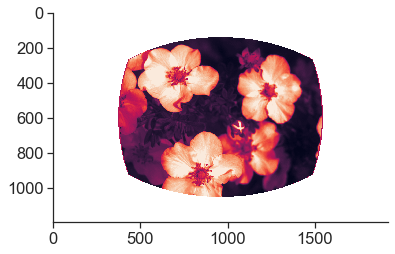

In [194]:
# apply mask to resized cropped image
cropped_image = mask*resized_image
plt.imshow(cropped_image)

Cropped images are luminance matched prior to warping. Let's make sure that the cropped image is close to mean gray (127)

In [203]:
image_mean = np.nanmean(cropped_image)
image_mean

126.6222997017028

#### warp image

Here we simulate the stimulus monitor and warp the cropped, resized image to view the pixel values as they were displayed on the monitor during the experiment

In [195]:
from allensdk.brain_observatory.stimulus_info import BrainObservatoryMonitor

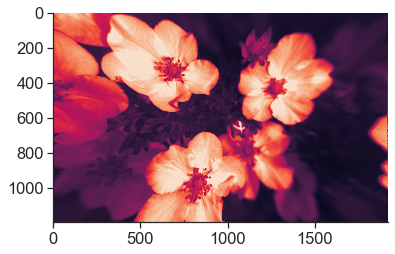

In [197]:
# Use known Brain Observatory monitor geometry (size, angle, distance from eye, etc) to warp the image
brain_observatory_monitor = BrainObservatoryMonitor()
warped_image = brain_observatory_monitor.warp_image(img=resized_image)
plt.imshow(warped_image)

#### compute warped image contrast and other measures

In [198]:
image_std = np.std(warped_image)
image_std

65.69994438713016

In [199]:
image_max = np.amax(warped_image)
image_min = np.amin(warped_image)
image_range = image_max-image_mean
image_range

116.43768302323768

In [200]:
image_mean = np.mean(warped_image)
image_mean

116.88162239583333

### Repeat for all image sets and save to file 

In [204]:
from allensdk.brain_observatory.stimulus_info import Monitor
from allensdk.brain_observatory.stimulus_info import BrainObservatoryMonitor

In [210]:
image_set_dictionary = {}
image_set_dictionary['images_A'] = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_training_2017.07.14.pkl"
image_set_dictionary['images_B'] = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_ophys_6_2017.07.14.pkl"
image_set_dictionary['images_G'] = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_ophys_G_2019.05.26.pkl"
image_set_dictionary['images_H'] = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\image_dictionaries\Natural_Images_Lum_Matched_set_ophys_H_2019.05.26.pkl"


In [229]:
images_df = pd.DataFrame(columns=['image_set','image_name','cropped_image','warped_image',
                                 'cropped_image_mean','cropped_image_min','cropped_image_max','cropped_image_range','cropped_image_std',
                                 'warped_image_mean','warped_image_min','warped_image_max','warped_image_range','warped_image_std',])
i=0
for image_set in list(image_set_dictionary.keys()):
    
    # get image data for this image set
    images = pd.read_pickle(image_set_dictionary[image_set])

    # input known screen size (24 inch) and pixel resolution of images
    monitor = Monitor(n_pixels_c=1920, n_pixels_r=1200, panel_size=60.96, spatial_unit='cm')

    # loop through images
    image_names = list(images.keys())
    
    for image_name in image_names: 
        
        images_df.at[i, 'image_set'] = image_set
        images_df.at[i, 'image_name'] = image_name

        # get image array from images dictionary
        image_array = images[image_name][image_name]

        # resize image to fit monitor dimensions
        resized_image = monitor.natural_scene_image_to_screen(image_array, origin='upper')

        # get the cropping mask in screen coordinates
        mask = monitor.get_mask()
        mask[mask==0] = np.nan

        # apply mask to resized cropped image
        cropped_image = mask*resized_image

        images_df.at[i, 'cropped_image'] = cropped_image
        
        # get metrics for cropped image     
        images_df.at[i, 'cropped_image_mean'] = np.nanmean(cropped_image)
        images_df.at[i, 'cropped_image_min'] = np.nanmin(cropped_image)
        images_df.at[i, 'cropped_image_max'] = np.nanmax(cropped_image)
        images_df.at[i, 'cropped_image_range'] = np.nanmax(cropped_image)-np.nanmin(cropped_image)
        images_df.at[i, 'cropped_image_std'] = np.nanstd(cropped_image)

        # Use known Brain Observatory monitor geometry (size, angle, distance from eye, etc) to warp the image
        brain_observatory_monitor = BrainObservatoryMonitor()
        warped_image = brain_observatory_monitor.warp_image(img=resized_image)

        images_df.at[i, 'warped_image'] = warped_image
        
        # get metrics for warped image     
        images_df.at[i, 'warped_image_mean'] = np.nanmean(warped_image)
        images_df.at[i, 'warped_image_min'] = np.nanmin(warped_image)
        images_df.at[i, 'warped_image_max'] = np.nanmax(warped_image)
        images_df.at[i, 'warped_image_range'] = np.nanmax(warped_image)-np.nanmin(warped_image)
        images_df.at[i, 'warped_image_std'] = np.nanstd(warped_image)
        
        i+=1

In [401]:
# save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\2020_cache\production_cache'
# images_df.to_hdf(os.path.join(save_dir, 'images_df.h5'), key='df')
# image_metrics_only = images_df.drop(columns=['cropped_image', 'warped_image'])
# image_metrics_only.to_hdf(os.path.join(save_dir, 'image_metrics_df.h5'), key='df')

### plot images in order of increasing contrast

In [232]:
images_df = images_df.sort_values(by='warped_image_std')

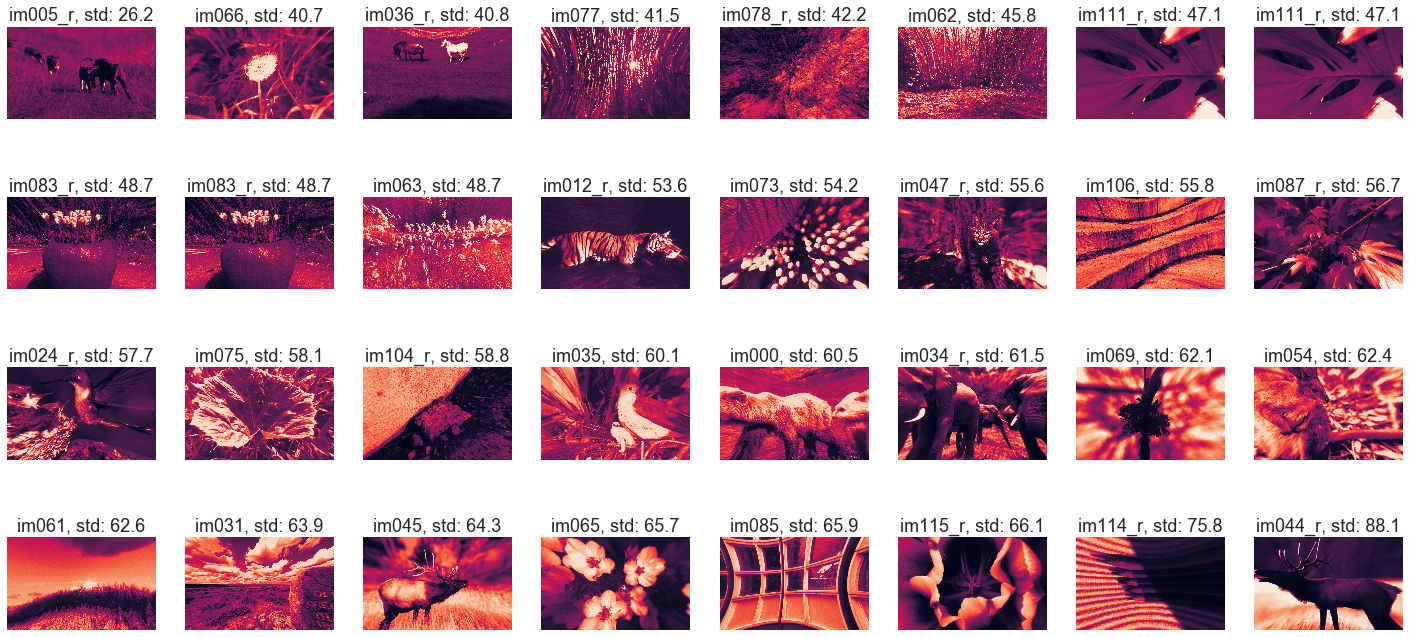

In [233]:
fig, ax = plt.subplots(4,8, figsize=(25,12))
ax = ax.ravel()
for i, row in enumerate(range(len(images_df))):
    ax[i].imshow(images_df.iloc[i].warped_image)
    ax[i].set_title(images_df.iloc[i].image_name+', std: '+str(np.round(images_df.iloc[i].warped_image_std,1)))
    ax[i].axis('off')